<a href="https://colab.research.google.com/github/JuanFdoGf/PracticasDS/blob/main/Perceptr%C3%B3nMulticapa_Identificaci%C3%B3nAudio_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Procesamiento del audio

<function matplotlib.pyplot.show(close=None, block=None)>

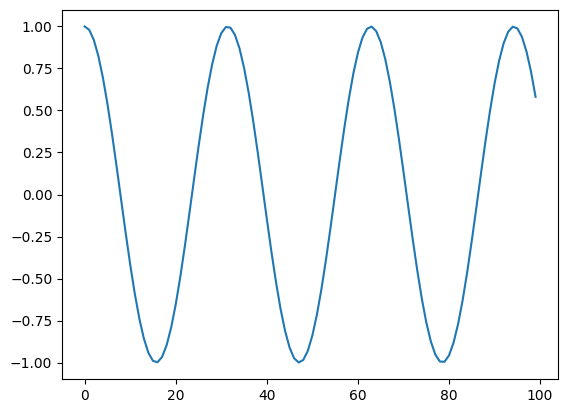

In [1]:
import numpy as np
from matplotlib import pyplot as plt

signal = np.cos(np.arange(0, 20, 0.2))
plt.plot(signal)
plt.show

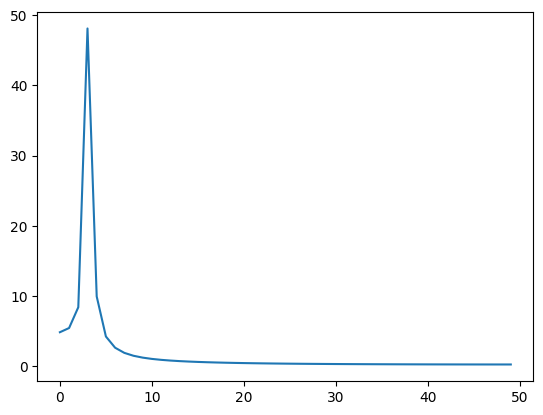

In [2]:
# Necesitamos un método que, dada una onda digital, nos devuelva las frecuencias en ella. Para ello utilizaremos la Transformada de Fourier.
fft = np.fft.fft(signal)[:50]
fft = np.abs(fft)

plt.plot(fft)
plt.show()

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kongaevans/speaker-recognition-dataset")

print("Path to dataset files:", path)

100%|██████████| 231M/231M [00:03<00:00, 62.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/kongaevans/speaker-recognition-dataset/versions/1


In [4]:
# Definimos un conjunto de constantes con las rutas de las carpetas que contienen los audios de cada persona
import os

DATASET_ROOT = '/root/.cache/kagglehub/datasets/kongaevans/speaker-recognition-dataset/versions/1/16000_pcm_speeches'
BENJAMIN_DATA = os.path.join(DATASET_ROOT, 'Benjamin_Netanyau')
JENS_DATA = os.path.join(DATASET_ROOT, 'Jens_Stoltenberg')
JULIA_DATA = os.path.join(DATASET_ROOT, 'Julia_Gillard')
MARGARET_DATA = os.path.join(DATASET_ROOT, 'Margaret_Tarcher')
NELSON_DATA = os.path.join(DATASET_ROOT, 'Nelson_Mandela')

In [5]:
import librosa

wav, sr = librosa.load(os.path.join(BENJAMIN_DATA, '22.wav'))

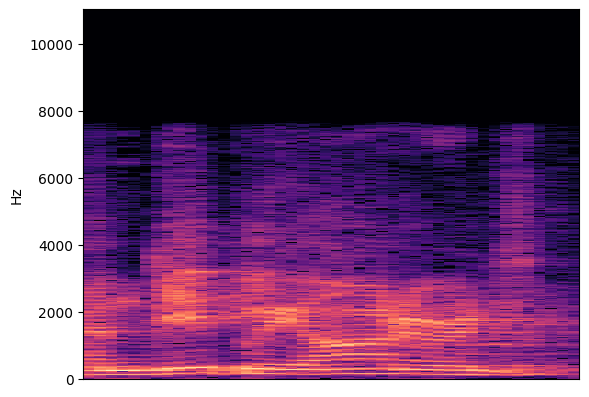

In [6]:
import librosa.display

D = librosa.amplitude_to_db(np.abs(librosa.stft(wav)), ref=np.max)

librosa.display.specshow(D, y_axis='linear')
plt.show()

In [7]:
# El espectrograma puede interpretarse como una imagen
D.shape

(1025, 44)

##1. Preparación del conjunto de datos

In [8]:
# Definimos una función para partsear nuestro conjunto de datos
def parse_dataset(dataset_paths):
    X = []
    y = []
    for index, dataset in enumerate(dataset_paths):
        print('[+] Parsing {} data...'.format(dataset))
        for fname in os.listdir(dataset):
            wav, sr = librosa.load(os.path.join(dataset, fname), sr=None)
            D = librosa.amplitude_to_db(np.abs(librosa.stft(wav)), ref=np.max)
            X.append(D)
            y.append(index)
    return (X, y)

In [9]:
X_prep, y_prep = parse_dataset([BENJAMIN_DATA, JENS_DATA])

[+] Parsing /root/.cache/kagglehub/datasets/kongaevans/speaker-recognition-dataset/versions/1/16000_pcm_speeches/Benjamin_Netanyau data...
[+] Parsing /root/.cache/kagglehub/datasets/kongaevans/speaker-recognition-dataset/versions/1/16000_pcm_speeches/Jens_Stoltenberg data...


##2. División del conjunto de datos

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_prep, y_prep, test_size=0.05)

In [12]:
X_train[0].shape

(1025, 32)

##3. Construcción del modelo

In [13]:
X_train_prep = np.array(X_train).reshape((len(X_train), 1025*32))
X_train_prep = np.array(X_train_prep).astype('float32') / 255
y_train_prep = np.array(y_train)

X_test_prep = np.array(X_test).reshape((len(X_test), 1025*32))
X_test_prep = np.array(X_test_prep).astype('float32') / 255
y_test_prep = np.array(y_test)

In [14]:
# Entrenamos un perceptrón multicapa
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(activation='logistic', hidden_layer_sizes=(10,), solver='sgd')
clf.fit(X_train_prep, y_train_prep)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(activation='logistic', hidden_layer_sizes=(10,), solver='sgd')

In [15]:
# Realizamos una predicción con el conjunto de datos de prueba
y_prep = clf.predict(X_test_prep)

In [16]:
# Mostramos el f1_score resultante de la clasificación
from sklearn.metrics import f1_score

f1_score(y_test, y_prep, average='binary')

0.9655172413793104